# Финальный проект: школа DA – анализ данных Real Estate 

В этом задании вам нужно будет проанализировать данные об объектах недвижимости в России на период 2018-2021. 

Ссылка на данные: https://drive.google.com/file/d/10Ns8WiQu_5Ys6iSQrm_oPGgRTMG4wpTK/view?usp=sharing

В таблице хранится информация о более 600 тыс объектах недвижимости. Данные собраны с различных интернет-порталов. 

В таблице 13 полей: 
* `date` - дата публикации объявления
* `time` - время публикации объявления
* `geo_lat` - широта (координаты объекта)
* `geo_lon` - долгота (координаты объекта) 
* `region` - регион
* `building_type` - тип строения. 0 - Other. 1 - Panel. 2 - Monolithic. 3 - Brick. 4 - Blocky. 5 - Wooden
* `object_type` - тип объекта недвижимости. 1 - Secondary real estate market; 2 - New building;
* `level` - этаж
* `levels` - количество этажей
* `rooms` - количество комнат. Значение -1 означает студию. 
* `area` - площадь объекта 
* `kitchen_area` - площадь кухни 
* `price` - цена в рублях 

Предупреждение: в данных могут быть ошибки / выбросы / аномалии из-за технических ошибок. К сожалению, на практике такое часто случается :) При необходимости вы можете использовать дополнительные данные из внешних источников. 




## Вопросы 



1. Наблюдается ли сезонность в динамике количества опубликованных объявлений? 
2. Какие квартиры самые дорогие? Составьте описательный портрет. 
3. Какие квартиры самые дешевые? Составьте описательный портрет. 
4. Как ведут себя цены на недвижимость в динамике? 
5. Есть ли в таблице аномально странные объекты? Например, объекты со слишком дорогой ценой или слишком большим количеством комнат? Приведите примеры конкретных объектов. 
6. В каких регионах рынок недвижимости растет? А в каких падает? 
7. В покупку квартир какого сегмента вы бы инветировали и почему? 


# **0.Подготовительные действия**

**Устанавливаю библиотеку для идентификации региона России по координатам**

In [1]:
pip install geopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Импорт необходимых модулей**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from geopy.geocoders import Nominatim
mpl.style.use(['Solarize_Light2'])

**Загрузка предоставленного датасета**

In [3]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

**Чтение данных с помощью pandas**

In [4]:
data = pd.read_csv('data.csv')

**Составление тепловой карты значений в датасете. Желтый - значение есть, синий - значения нет**

Количество пропущенных значений: 0


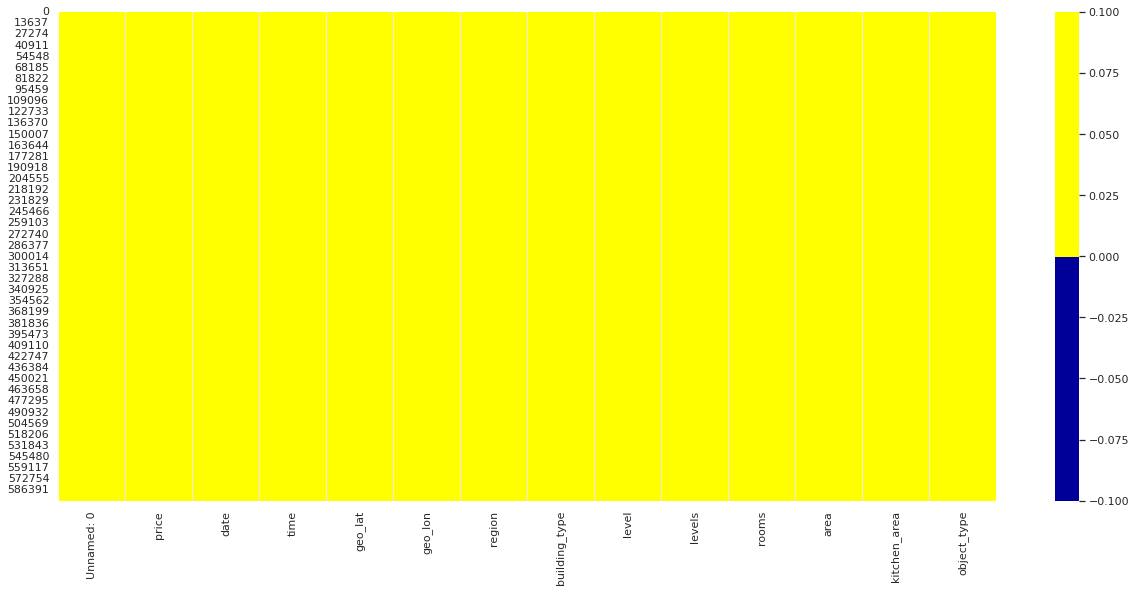

In [5]:
sns.set (rc = {'figure.figsize' : (21,9)})
cols = data.columns
colors = ['#000099', '#ffff00']
sns.heatmap(data[cols].isnull(), cmap = sns.color_palette(colors))
print(f'Количество пропущенных значений: {data.isnull().sum().sum()}')

**Переименование переменной и группировка данных по региону, вывод полей Широты, Долготы и Кода региона**

In [6]:
data = data.groupby('region')[['geo_lat', 'geo_lon', 'region' ]].head(1)

**Задание функции поиска адреса объекта по координатам**

In [7]:
def get_address_by_location(latlong, language='ru'):
    app = Nominatim(user_agent='grabylnikov')
    try:
        return app.reverse(latlong, language=language).raw
    except:
        return get_address_by_location(latlong)

**Добавление дополнительного поля ШиротаДолгота, в котором будут объединены данные из полей Широта и Долгота**

In [8]:
data['latlong'] = list(zip(data['geo_lat'], data['geo_lon']))

**Создание пустого списка**

In [9]:
lst = []

**Создание датафрейма, содержащего адрес объекта**

In [10]:
df = pd.DataFrame(lst, columns=['geo_lat', 'geo_lon', 'Регион', 'Город/ПГТ/Село', 'Улица', 'Номер дома'])

**Цикл поиска по геоданным и датасету адресов объектов недвижимости**

Решил не применять случайную выборку .sample(frac = 0.25)
Циклу подаются сгруппированные данные по кодам регионов (их 82), чтобы избежать обработки 600 тысяч записей датасета в течение 4 суток из-за ограничения скорости работы библотеки geopy.

In [11]:
for i in tqdm(range(len(data))):
    latlong = data.iloc[i]['latlong']
    address = get_address_by_location(latlong)
    element = [data.iloc[i]['geo_lat'],
            data.iloc[i]['geo_lon'],
            address['address']['state'] if 'state' in address['address'] else '',
            address['address']['city'] if 'city' in address['address'] 
            else (address['address']['village'] if 'village' in address['address']\
            else(address['address']['town'] if 'town' in address['address'] else '')),
            address['address']['road'] if 'road' in address['address'] else '',
            address['address']['house_number'] if 'house_number' in address['address'] else '']
    lst.append(element)

100%|██████████| 82/82 [00:41<00:00,  2.00it/s]


**Замена кода региона на наименование региона**

In [12]:
df = pd.DataFrame(lst, columns=['geo_lat', 'geo_lon', 'Регион', 'Город/ПГТ/Село', 'Улица', 'Номер дома'])

**Добавление в датафрейм, содержащий адреса объектов, дополнительного поля ШиротаДолгота, в котором будут объединены данные из полей Широта и Долгота**

In [13]:
df['latlong'] = list(zip(df['geo_lat'], df['geo_lon']))

**Объединение двух датасетов в один**

In [14]:
data_df = pd.merge(data, df, how = 'inner', on = 'latlong')

In [15]:
data_df.head()

,geo_lat_x,geo_lon_x,region,latlong,geo_lat_y,geo_lon_y,Регион,Город/ПГТ/Село,Улица,Номер дома
0,61.657787,50.831367,4417,"(61.657787, 50.831367)",61.657787,50.831367,Республика Коми,Сыктывкар,Октябрьский проспект,2
1,55.876059,37.388217,81,"(55.8760589, 37.3882166)",55.876059,37.388217,Московская область,Путилково,Сходненская улица,19
2,59.911622,30.284556,2661,"(59.9116217, 30.2845562)",59.911622,30.284556,Санкт-Петербург,Санкт-Петербург,Курляндская улица,18
3,54.524271,52.807177,2922,"(54.524271, 52.807177)",54.524271,52.807177,Татарстан,Бугульма,улица Тухачевского,15
4,43.484765,43.594212,9648,"(43.4847646, 43.5942119)",43.484765,43.594212,Кабардино-Балкария,Нальчик,улица Арманд,43


**Сортировка регионов по возрастанию значения кода**

In [16]:
data_df.sort_values('region')

,geo_lat_x,geo_lon_x,region,latlong,geo_lat_y,geo_lon_y,Регион,Город/ПГТ/Село,Улица,Номер дома
6,55.704428,37.766989,3,"(55.704428, 37.766989)",55.704428,37.766989,Москва,Москва,Волгоградский проспект (дублёр),82/37
80,48.804556,132.879747,69,"(48.8045557, 132.8797474)",48.804556,132.879747,Еврейская автономная область,Биробиджан,Парковая улица,12
1,55.876059,37.388217,81,"(55.8760589, 37.3882166)",55.876059,37.388217,Московская область,Путилково,Сходненская улица,19
67,53.323544,34.309142,821,"(53.3235438, 34.3091419)",53.323544,34.309142,Брянская область,Брянск,Коммунальная улица,2
21,56.452237,53.784255,1010,"(56.4522374, 53.7842545)",56.452237,53.784255,Удмуртия,городской округ Сарапул,улица Ленина,59
...,...,...,...,...,...,...,...,...,...,...
42,43.234464,44.735823,13913,"(43.234464, 44.735823)",43.234464,44.735823,Ингушетия,Назрань,Новая улица,16
29,43.043523,44.627729,13919,"(43.0435232, 44.6277287)",43.043523,44.627729,Северная Осетия — Алания,Владикавказ,Весенняя улица,
61,68.889270,33.098741,14368,"(68.8892702, 33.0987412)",68.889270,33.098741,Мурманская область,Мурманск,улица Героев Рыбачьего,48
72,63.799053,74.489071,14880,"(63.7990527, 74.4890715)",63.799053,74.489071,Ямало-Ненецкий автономный округ,городской округ Муравленко,улица Ленина,125


**Теперь, когда видно соответствие кода и наименования региона, можно начать процесс переименования**

Снова чтение оригинального предоставленного изначально датасета

In [17]:
data = pd.read_csv('data.csv')

**И переименование кода региона в наименование региона**

In [ ]:
['Республика Бурятия', 'Республика Саха (Якутия)', 'Камчатский край', 'Хабаровский край', 
 'Забайкальский край', 'Приморский край', 'Еврейская автономная область', 'Магаданская область']

In [18]:
data.loc[data['region'] == 3, 'region' ] = 'Москва'
data.loc[data['region'] == 69, 'region' ] = 'Еврейская автономная область'
data.loc[data['region'] == 81, 'region' ] = 'Московская область'
data.loc[data['region'] == 821, 'region' ] = 'Брянская область'
data.loc[data['region'] == 1010, 'region' ] = 'Удмуртия'
data.loc[data['region'] == 1491, 'region' ] = 'Рязанская область'
data.loc[data['region'] == 2072, 'region' ] = 'Воронежская область'
data.loc[data['region'] == 2328, 'region' ] = 'Калужская область'
data.loc[data['region'] == 2359, 'region' ] = 'Республика Хакасия'
data.loc[data['region'] == 2484, 'region' ] = 'Ханты-Мансийский автономный округ — Югра'
data.loc[data['region'] == 2528, 'region' ] = 'Саратовская область'
data.loc[data['region'] == 2594, 'region' ] = 'Кировская область'
data.loc[data['region'] == 2604, 'region' ] = 'Ярославская область'
data.loc[data['region'] == 2661, 'region' ] = 'Санкт-Петербург'
data.loc[data['region'] == 2722, 'region' ] = 'Башкортостан'
data.loc[data['region'] == 2806, 'region' ] = 'Тамбовская область'
data.loc[data['region'] == 2814, 'region' ] = 'Орловская область'
data.loc[data['region'] == 2843, 'region' ] = 'Краснодарский край'
data.loc[data['region'] == 2860, 'region' ] = 'Кемеровская область'
data.loc[data['region'] == 2871, 'region' ] = 'Нижегородская область'
data.loc[data['region'] == 2880, 'region' ] = 'Тверская область'
data.loc[data['region'] == 2885, 'region' ] = 'Чеченская Республика'
data.loc[data['region'] == 2900, 'region' ] = 'Ставропольский край'
data.loc[data['region'] == 2922, 'region' ] = 'Татарстан'
data.loc[data['region'] == 3019, 'region' ] = 'Чувашия'
data.loc[data['region'] == 3106, 'region' ] = 'Самарская область'
data.loc[data['region'] == 3153, 'region' ] = 'Оренбургская область'
data.loc[data['region'] == 3230, 'region' ] = 'Ростовская область'
data.loc[data['region'] == 3446, 'region' ] = 'Ленинградская область'
data.loc[data['region'] == 3870, 'region' ] = 'Красноярский край'
data.loc[data['region'] == 3991, 'region' ] = 'Тюменская область'
data.loc[data['region'] == 4007, 'region' ] = 'Дагестан'
data.loc[data['region'] == 4086, 'region' ] = 'Хабаровский край'
data.loc[data['region'] == 4189, 'region' ] = 'Костромская область'
data.loc[data['region'] == 4240, 'region' ] = 'Липецкая область'
data.loc[data['region'] == 4249, 'region' ] = 'Ульяновская область'
data.loc[data['region'] == 4374, 'region' ] = 'Вологодская область'
data.loc[data['region'] == 4417, 'region' ] = 'Республика Коми'
data.loc[data['region'] == 4695, 'region' ] = 'Волгоградская область'
data.loc[data['region'] == 4963, 'region' ] = 'Приморский край'
data.loc[data['region'] == 4982, 'region' ] = 'Марий Эл'
data.loc[data['region'] == 5143, 'region' ] = 'Тульская область'
data.loc[data['region'] == 5178, 'region' ] = 'Республика Тыва'
data.loc[data['region'] == 5241, 'region' ] = 'Мордовия'
data.loc[data['region'] == 5282, 'region' ] = 'Челябинская область'
data.loc[data['region'] == 5368, 'region' ] = 'Иркутская область'
data.loc[data['region'] == 5520, 'region' ] = 'Пермский край'
data.loc[data['region'] == 5703, 'region' ] = 'Курганская область'
data.loc[data['region'] == 5736, 'region' ] = 'Новгородская область'
data.loc[data['region'] == 5789, 'region' ] = 'Владимирская область'
data.loc[data['region'] == 5794, 'region' ] = 'Смоленская область'
data.loc[data['region'] == 5952, 'region' ] = 'Белгородская область	'
data.loc[data['region'] == 5993, 'region' ] = 'Пензенская область'
data.loc[data['region'] == 6171, 'region' ] = 'Свердловская область'
data.loc[data['region'] == 6309, 'region' ] = 'Республика Алтай'
data.loc[data['region'] == 6543, 'region' ] = 'Архангельская область'
data.loc[data['region'] == 6817, 'region' ] = 'Алтайский край'
data.loc[data['region'] == 6937, 'region' ] = 'Республика Крым'
data.loc[data['region'] == 7121, 'region' ] = 'Курская область'
data.loc[data['region'] == 7793, 'region' ] = 'Псковская область'
data.loc[data['region'] == 7873, 'region' ] = 'Крым'
data.loc[data['region'] == 7896, 'region' ] = 'Калининградская область'
data.loc[data['region'] == 7929, 'region' ] = 'Амурская область'
data.loc[data['region'] == 8090, 'region' ] = 'Республика Карелия'
data.loc[data['region'] == 8509, 'region' ] = 'Калмыкия'
data.loc[data['region'] == 8640, 'region' ] = 'Омская область'
data.loc[data['region'] == 8894, 'region' ] = 'Ивановская область'
data.loc[data['region'] == 9579, 'region' ] = 'Республика Бурятия'
data.loc[data['region'] == 9648, 'region' ] = 'Кабардино-Балкария'
data.loc[data['region'] == 9654, 'region' ] = 'Новосибирская область'
data.loc[data['region'] == 10160, 'region' ] = 'Забайкальский край'
data.loc[data['region'] == 10201, 'region' ] = 'Томская область'
data.loc[data['region'] == 10582, 'region' ] = 'Астраханская область'
data.loc[data['region'] == 11171, 'region' ] = 'Республика Саха (Якутия)'
data.loc[data['region'] == 11416, 'region' ] = 'Адыгея'
data.loc[data['region'] == 11991, 'region' ] = 'Карачаево-Черкесия'
data.loc[data['region'] == 13098, 'region' ] = 'Камчатский край'
data.loc[data['region'] == 13913, 'region' ] = 'Ингушетия'
data.loc[data['region'] == 13919, 'region' ] = 'Северная Осетия — Алания'
data.loc[data['region'] == 14368, 'region' ] = 'Мурманская область'
data.loc[data['region'] == 14880, 'region' ] = 'Ямало-Ненецкий автономный округ'
data.loc[data['region'] == 16705, 'region' ] = 'Магаданская область'

**Типы данных в датасете**

In [19]:
data.dtypes

Unnamed: 0         int64
price              int64
date              object
time              object
geo_lat          float64
geo_lon          float64
region            object
building_type      int64
level              int64
levels             int64
rooms              int64
area             float64
kitchen_area     float64
object_type        int64
dtype: object

**Перевод поля date из формата object в формат datetime64**

In [20]:
data['date'] = pd.to_datetime(data['date'])

In [ ]:
#df.to_csv(r'C:\df.csv', sep= ',', index=False) Сохранение датасета с внесенными изменениями

**Расчет дополнительного поля - цены за квадратный метр для конкретного объекта. Исхожу из того. что значение в поле kitchen_area является частью поля area, и складывать их не нужно.**

In [21]:
data['price_per_meter'] = round(data['price'] / data['area'], 2)

# ***1. Наблюдается ли сезонность в динамике количества опубликованных объявлений?***

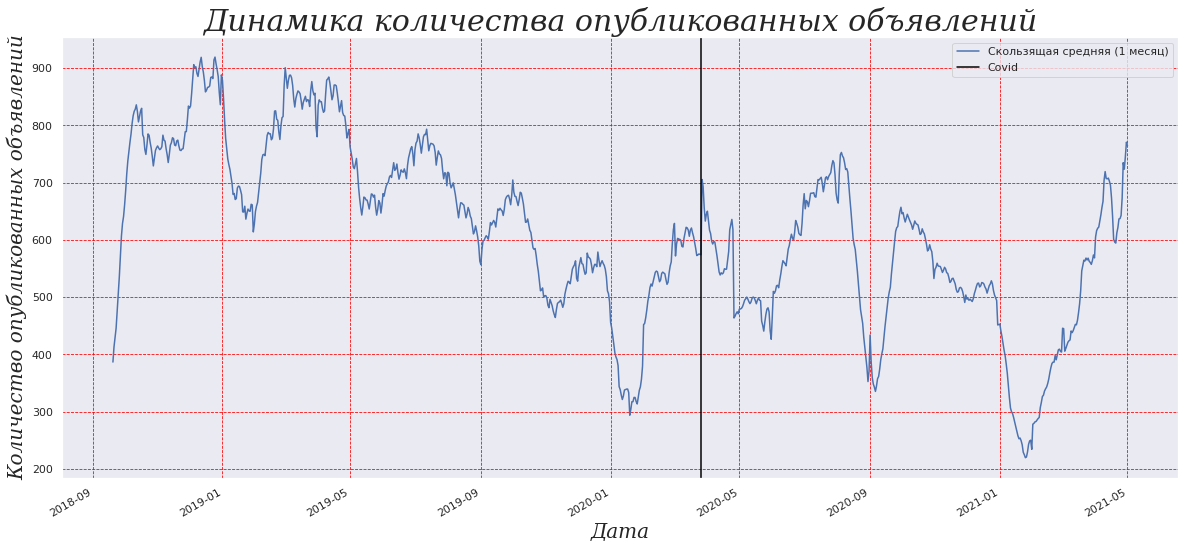

In [23]:
plt.figure(figsize = (20,9))
ads = data.groupby('date').count()['region']
ads.rolling(30).mean().plot(label = 'Скользящая средняя (1 месяц)')
plt.title('Динамика количества опубликованных объявлений', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 30)
plt.xlabel('Дата', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 20)
plt.ylabel('Количество опубликованных объявлений', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 20)
plt.axvline (x=mpl.dates.datestr2num('2020-03-26'), color = 'black', label = 'Covid')
plt.minorticks_on()
plt.grid(which = 'major', color = 'red', linewidth = 0.8, linestyle = '--')
plt.legend()
plt.show()


**Вывод: сезонность по количеству заявок присутствует на всем временном отрезке. Рост количества заявок стабильно наблюдается в март-апрель (3-4), июль(7), сентябрь(9) и декабрь(12). Снижение количества происходит в феврале(2), июне(6), августе (8) и ноябре (11). Также на данных с приходом ковида сезонность сохраняется, но колебания количества увеличиваются более чем двукратно - с 200 до 400-500.**

# ***5.Есть ли в таблице аномально странные объекты? Например, объекты со слишком дорогой ценой или слишком большим количеством комнат? Приведите примеры конкретных объектов.***

**Пределов у человеческого тщеславия нет. Количество комнат может идти на десятки, также как одна только кухня может быть площадью десятки, и даже сотни квадратных метров. Сосредотачиваюсь на поиске нереалистичных значений через поле price_per_meter, и его процентили, которое покажет ошибки в строке объекта в процессе заполнения его полей.**

**В ячейке ниже аномальные минимальные значения площади объекта недвижимости по регионам**

In [24]:
data.groupby('region')['price', 'building_type', 'level', 'levels','rooms', 'area', 'kitchen_area', 'price_per_meter'].agg('min').sort_values('area').head(20)

<ipython-input-24-458f1cf63531>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data.groupby('region')['price', 'building_type', 'level', 'levels','rooms', 'area', 'kitchen_area', 'price_per_meter'].agg('min').sort_values('area').head(20)


,price,building_type,level,levels,rooms,area,kitchen_area,price_per_meter
region,,,,,,,,
Новосибирская область,-2114150296,0,1,1,-2,0.22,0.03,-38777051.02
Челябинская область,750,0,1,1,-1,0.28,0.05,23.44
Свердловская область,600,0,1,1,-1,0.79,0.07,0.84
Краснодарский край,-1156247296,0,1,1,-1,1.00,0.10,-18529604.10
Башкортостан,1750,0,1,1,-1,1.00,0.60,34.31
Татарстан,-1054967296,0,1,1,-2,1.00,0.06,-22934071.65
Московская область,2700,0,1,1,-2,1.00,0.10,61.58
Москва,500,0,1,1,-2,1.40,0.20,1.11
Алтайский край,610,0,1,1,-2,1.85,0.60,13.56


**Проверяю колонки на отрицательные значения**

**Поле price - группировка по регионам**

In [25]:
data.loc[(data['price'] < 0)].groupby('region').count()

,Unnamed: 0,price,date,time,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,price_per_meter
region,,,,,,,,,,,,,,
Краснодарский край,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Нижегородская область,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Новосибирская область,36,36,36,36,36,36,36,36,36,36,36,36,36,36
Санкт-Петербург,3,3,3,3,3,3,3,3,3,3,3,3,3,3
Татарстан,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Тюменская область,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [26]:
print(f"Количество объектов {len(data.loc[(data['price'] < 0)])}")

Количество объектов 44


**Поле building_type - группировка по регионам**

In [27]:
data.loc[(data['building_type'] < 0)].groupby('region').count()

,Unnamed: 0,price,date,time,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,price_per_meter
region,,,,,,,,,,,,,,


In [28]:
print(f"Количество объектов {len(data.loc[(data['building_type'] < 0)])}")

Количество объектов 0


**Поле level - группировка по регионам**


In [29]:
data.loc[(data['level'] < 0)].groupby('region').count()

,Unnamed: 0,price,date,time,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,price_per_meter
region,,,,,,,,,,,,,,


In [30]:
print(f"Количество объектов {len(data.loc[(data['level'] < 0)])}")

Количество объектов 0


**Поле levels - группировка по регионам**

In [31]:
data.loc[(data['levels'] < 0)].groupby('region').count()

,Unnamed: 0,price,date,time,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,price_per_meter
region,,,,,,,,,,,,,,


In [32]:
print(f"Количество объектов {len(data.loc[(data['levels'] < 0)])}")

Количество объектов 0


**Поле rooms - группировка по регионам**

In [33]:
data.loc[(data['rooms'] < -1)].groupby('region').count()

,Unnamed: 0,price,date,time,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,price_per_meter
region,,,,,,,,,,,,,,
Алтайский край,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Владимирская область,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Москва,4,4,4,4,4,4,4,4,4,4,4,4,4,4
Московская область,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Нижегородская область,3,3,3,3,3,3,3,3,3,3,3,3,3,3
Новосибирская область,2,2,2,2,2,2,2,2,2,2,2,2,2,2
Санкт-Петербург,14,14,14,14,14,14,14,14,14,14,14,14,14,14
Ставропольский край,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Татарстан,3,3,3,3,3,3,3,3,3,3,3,3,3,3


In [34]:
print(f"Всего {len(data.loc[(data['rooms'] < -1)])} объекта")

Всего 35 объекта


**Поле area - группировка по регионам**

In [35]:
data.loc[(data['area'] < 0)].groupby('region').count()

,Unnamed: 0,price,date,time,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,price_per_meter
region,,,,,,,,,,,,,,


In [36]:
print(f"Всего {len(data.loc[(data['area'] < 0)])} объекта")

Всего 0 объекта


**Поле kitchen_area - группировка по регионам**

In [37]:
data.loc[(data['kitchen_area'] < 0)].groupby('region').count()

,Unnamed: 0,price,date,time,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,price_per_meter
region,,,,,,,,,,,,,,


In [38]:
print(f"Всего {len(data.loc[(data['kitchen_area'] < 0)])} объекта")

Всего 0 объекта


**Поле object_type - группировка по регионам**

In [39]:
data.loc[(data['object_type'] < 0)].groupby('region').count()

,Unnamed: 0,price,date,time,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,price_per_meter
region,,,,,,,,,,,,,,


In [40]:
print(f"Всего {len(data.loc[(data['object_type'] < 0)])} объекта")

Всего 0 объекта


**Отрицательные значения найдены в полях price и rooms. Известно, что значение -1 в поле rooms означает квартиру-студию. Допускаю, что ошибка -2 в поле rooms - это опечатка, поэтому: -2 исправляю на 2.**

In [41]:
data.loc[data['rooms'] == -2, 'rooms'] = 2

**Выявление объектов с явно нереалистичной ценой за квадратный метр (либо слишком малой, либо слишком большой).**

In [42]:
Q_01 = data['price_per_meter'].quantile(0.01) # 1% граница нижнего ценового диапазона за кв.м
Q_99 = data['price_per_meter'].quantile(0.99) # 99% граница верхнего ценового диапазона за кв.м
data_err = data[(data['price_per_meter'] < Q_01 ) | (data['price_per_meter'] > Q_99)]
print(f'1% граница нижнего ценового диапазона за кв.м: {Q_01} рублей')
print(f'99% граница верхнего ценового диапазона за кв.м: {Q_99} рублей')
print(f'Всего объектов с явно нереалистичной ценой: {len(data_err)}')

1% граница нижнего ценового диапазона за кв.м: 18000.0 рублей
99% граница верхнего ценового диапазона за кв.м: 305588.4800000002 рублей
Всего объектов с явно нереалистичной ценой: 11985


In [ ]:
#data_err.reset_index(inplace = True)

In [43]:
data_err.groupby('region').min()

,Unnamed: 0,price,date,time,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,price_per_meter
region,,,,,,,,,,,,,,
Адыгея,9570,1500,2018-09-18,01:37:03,44.783994,38.932751,2,1,1,1,35.00,7.20,1,20.83
Алтайский край,508,610,2018-09-08,01:11:27,50.866271,78.335991,1,1,1,-1,1.85,0.64,1,13.56
Амурская область,66232,180000,2018-11-30,00:29:29,50.106411,124.746890,1,1,1,1,32.00,6.00,1,4285.71
Архангельская область,67454,400000,2018-11-30,12:54:15,61.115640,40.502466,5,1,2,1,30.10,6.00,1,6989.25
Астраханская область,310816,700000,2019-11-05,15:49:28,46.346383,48.052015,3,1,2,2,8.69,1.60,1,1174.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Челябинская область,829,750,2018-09-09,00:05:06,52.661370,57.215862,0,1,1,-1,0.28,0.06,1,23.44
Чеченская Республика,316770,1000,2019-11-17,01:14:10,43.087072,45.083543,1,1,1,1,6.30,0.70,1,5.71
Чувашия,6280,700,2018-09-16,00:07:13,54.825848,46.156463,1,1,1,1,3.10,0.90,1,25.00


In [44]:
data_err.groupby('region').max()

,Unnamed: 0,price,date,time,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,price_per_meter
region,,,,,,,,,,,,,,
Адыгея,359514,1750000,2020-02-14,19:40:32,45.028126,40.547797,3,4,5,4,320.0,100.0,1,17500.00
Алтайский край,589776,7300000,2021-04-23,22:33:59,53.992179,86.195369,5,15,18,6,816.0,61.0,11,733333.33
Амурская область,474487,850000,2020-09-03,14:27:53,55.154644,129.439181,5,4,5,3,65.0,13.0,1,15625.00
Архангельская область,370487,900000,2020-03-02,23:17:53,64.701330,47.977926,5,2,2,4,93.0,14.0,1,13289.04
Астраханская область,404711,6150000,2020-05-02,22:29:06,46.534233,48.349212,5,6,9,3,596.0,24.0,1,707710.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Челябинская область,585152,444444444,2021-04-14,23:53:36,56.085149,62.982171,5,18,19,5,806.0,72.0,11,13071895.41
Чеченская Республика,596807,6000000,2021-04-30,23:13:47,43.649852,46.135462,4,20,20,5,4545.0,48.0,11,666666.67
Чувашия,598037,100000000,2021-04-30,23:56:06,56.187918,48.257773,5,14,16,4,5985.0,100.0,11,11111111.11


**Считаю данные объекты выбросами - данные введены с ошибкой - удаляю строки из датасета**

In [46]:
data = data[(data['price_per_meter'] > Q_01 ) & (data['price_per_meter'] < Q_99)]

**Примеры логических ошибок в заполнении данных**

In [45]:
data.loc[(data['area'] < 20 ) & (data['rooms'] > 3)].sort_values('rooms').head(5)

,Unnamed: 0,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,price_per_meter
235813,235813,1400000,2019-07-06,10:17:03,58.690840,59.488962,Свердловская область,4,1,5,4,7.4,1.0,1,189189.19
226605,226605,6400000,2019-06-26,13:28:16,56.062082,92.924994,Красноярский край,1,1,10,4,11.5,1.2,1,556521.74
305062,305062,3300000,2019-10-26,20:52:35,53.722153,91.423050,Республика Хакасия,1,9,10,4,7.8,9.0,1,423076.92
228949,228949,12000000,2019-06-28,19:40:28,59.694624,30.426886,Санкт-Петербург,3,1,5,4,11.5,1.2,1,1043478.26
441486,441486,4200000,2020-07-06,00:34:04,45.056747,39.026535,Краснодарский край,4,3,10,4,10.0,1.2,1,420000.00


# **2. Какие квартиры самые дорогие? Составьте описательный портрет.**

**С помощью 97.5 процентиля отбираю значения цены для high end сегмента недвижимости и их медиану**

In [47]:
high_end_segm = data['price'].quantile(q=0.975)
data[(data['price'] > high_end_segm)].sort_values('price')

,Unnamed: 0,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,price_per_meter
352449,352449,13950500,2020-02-01,11:14:33,45.023284,38.958793,Краснодарский край,0,13,22,3,148.50,27.60,1,93942.76
537651,537651,13951861,2020-12-30,23:30:44,55.753960,37.620393,Москва,2,22,26,3,76.40,17.70,11,182615.98
7711,7711,13952000,2018-09-18,00:27:50,59.981231,30.354002,Санкт-Петербург,3,4,10,3,87.20,33.08,1,160000.00
28316,28316,13953999,2018-10-12,15:06:05,55.850909,37.617527,Москва,2,7,11,3,84.93,14.89,11,164300.00
375525,375525,13954759,2020-03-11,21:32:07,59.896246,30.309932,Санкт-Петербург,2,14,19,3,106.10,22.10,11,131524.59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440095,440095,97000000,2020-07-03,09:12:04,43.585455,39.723155,Краснодарский край,2,5,7,5,361.00,46.00,1,268698.06
524877,524877,98991000,2020-12-01,19:13:27,59.994430,30.197023,Санкт-Петербург,2,22,24,4,340.00,20.00,1,291150.00
523790,523790,99500000,2020-11-30,20:43:15,56.327966,44.010770,Нижегородская область,0,9,10,5,360.00,53.00,1,276388.89
64502,64502,109500000,2018-11-28,14:31:27,59.962803,30.267478,Санкт-Петербург,2,10,11,5,384.00,100.00,11,285156.25


In [48]:
data[(data['price'] > high_end_segm)].agg({'price': 'median',
                                          'level': 'median',
                                          'levels': 'median',
                                          'rooms': 'median',
                                          'building_type': 'median',
                                          'area': 'median',
                                          'kitchen_area': 'median',
                                          'price_per_meter': 'median',
                                          'object_type': 'median'}).to_frame()

,0
price,17718867.00
level,6.00
levels,14.00
rooms,3.00
building_type,2.00
area,94.40
kitchen_area,16.30
price_per_meter,205862.63
object_type,1.00


**Описательный портрет дорогой квартиры. Это 3-комнатная квартира вторичного рынка недвижимости в 14-этажном монолитном здании, расположенная на 6 этаже площадью 95 квадратных метров и кухней 16 квадратных метров, стоимость которой примерно равна 17.7 млн рублей. Цена за квадратный метр 206 тысяч**

# **3. Какие квартиры самые дешевые? Составьте описательный портрет.**

**При составлении описательного портрета дешевых квартир, под квартирой подразумеваю площадь отдельного помещения не менее 18 квадратных метров. Поэтому вношу изменения в датасет, что именно считать квартирой**

In [49]:
data = data[(data['area'] >= 18)]

**С помощью 2,5 процентиля отбираю значения цены для low end сегмента недвижимости и их медиану**

In [50]:
low_end_segm = data['price'].quantile(q=0.025)
data[(data['price'] < low_end_segm)]

,Unnamed: 0,price,date,time,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type,price_per_meter
8,8,1000000,2018-07-03,15:35:00,45.102882,38.637617,Краснодарский край,1,2,3,1,40.00,12.00,1,25000.00
50,50,975000,2018-09-08,01:34:56,55.013916,83.003290,Новосибирская область,1,10,10,1,39.00,1.00,11,25000.00
62,62,1000000,2018-09-08,01:40:05,54.943610,82.962845,Новосибирская область,1,3,10,1,33.00,5.00,11,30303.03
99,99,963000,2018-09-08,01:54:26,54.947141,82.958596,Новосибирская область,1,1,10,1,32.12,4.00,11,29981.32
119,119,1003000,2018-09-08,02:07:40,55.013916,83.003290,Новосибирская область,1,6,10,1,39.35,4.39,11,25489.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599120,599120,950000,2021-05-01,08:18:30,57.160061,60.575353,Свердловская область,0,1,2,1,28.60,6.00,1,33216.78
599167,599167,1000000,2021-05-01,08:47:12,58.095512,38.736895,Ярославская область,3,1,3,2,43.00,6.00,1,23255.81
599421,599421,945000,2021-05-01,10:48:50,53.347860,58.979240,Челябинская область,1,8,10,-1,26.00,5.00,11,36346.15
599533,599533,550000,2021-05-01,12:44:51,57.743755,40.995876,Костромская область,3,5,5,1,18.00,7.00,1,30555.56


In [51]:
data[(data['price'] < low_end_segm)].agg({'price': 'median',
                                         'level': 'median',
                                         'levels': 'median',
                                         'rooms': 'median',
                                         'building_type': 'median',
                                         'area': 'median',
                                         'kitchen_area': 'median',
                                         'price_per_meter': 'median',
                                          'object_type': 'median'}).to_frame()

,0
price,910000.00
level,3.00
levels,5.00
rooms,1.00
building_type,3.00
area,32.47
kitchen_area,6.00
price_per_meter,28011.20
object_type,1.00


**Описательный портрет дешевой квартиры. Это 1-комнатная квартира вторичного рынка недвижимости в 5-этажном кирпичном здании, расположенная на 3 этаже площадью 32 квадратных метра и 6 метровой кухней, стоимостью у которой в районе 910 тысяч рублей. Цена за квадратный метр 28 тысяч рублей. Классическая советская хрущевка конца 60-х.**

# **4. Как ведут себя цены на недвижимость в динамике?**

**Скользящая средняя по цене квадратного метра.** 

In [52]:
data.set_index('date', inplace = True)

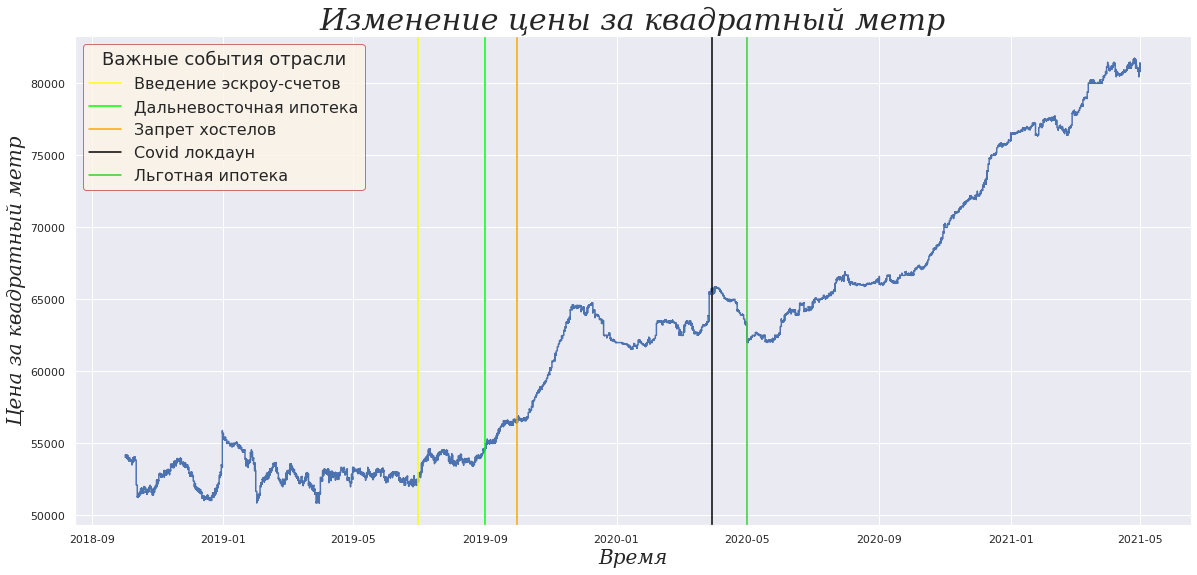

In [53]:
plt.figure(figsize = (20,9))
plt.plot(data['price_per_meter'].rolling(20000).median())
plt.title('Изменение цены за квадратный метр', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 30)
plt.xlabel('Время', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 20)
plt.ylabel('Цена за квадратный метр', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 20)
plt.axvline (x=mpl.dates.datestr2num('2019-07-01'), color = 'yellow', label = 'Введение эскроу-счетов')
plt.axvline (x=mpl.dates.datestr2num('2019-09-01'), color = 'lime', label = 'Дальневосточная ипотека')
plt.axvline (x=mpl.dates.datestr2num('2019-10-01'), color = 'orange', label = 'Запрет хостелов')
plt.axvline (x=mpl.dates.datestr2num('2020-03-30'), color = 'black', label = 'Covid локдаун')
plt.axvline (x=mpl.dates.datestr2num('2020-05-01'), color = 'limegreen', label = 'Льготная ипотека')
plt.minorticks_on()
#plt.grid(which = 'major', color = 'red', linewidth = 0.8, linestyle = '--')
#plt.grid(which = 'minor', color = 'green', linewidth = 0.5, linestyle = '--')
plt.legend(fontsize = 16,
          ncol = 1, #  количество столбцов
          facecolor = 'oldlace',    #  цвет области
          edgecolor = 'r',    #  цвет крайней линии
          title = 'Важные события отрасли',    #  заголовок
          title_fontsize = '18'    #  размер шрифта заголовка
         )
plt.show()

In [54]:
old = data.loc[(data['object_type'] == 1)]['price_per_meter']
new = data.loc[(data['object_type'] == 11)]['price_per_meter']

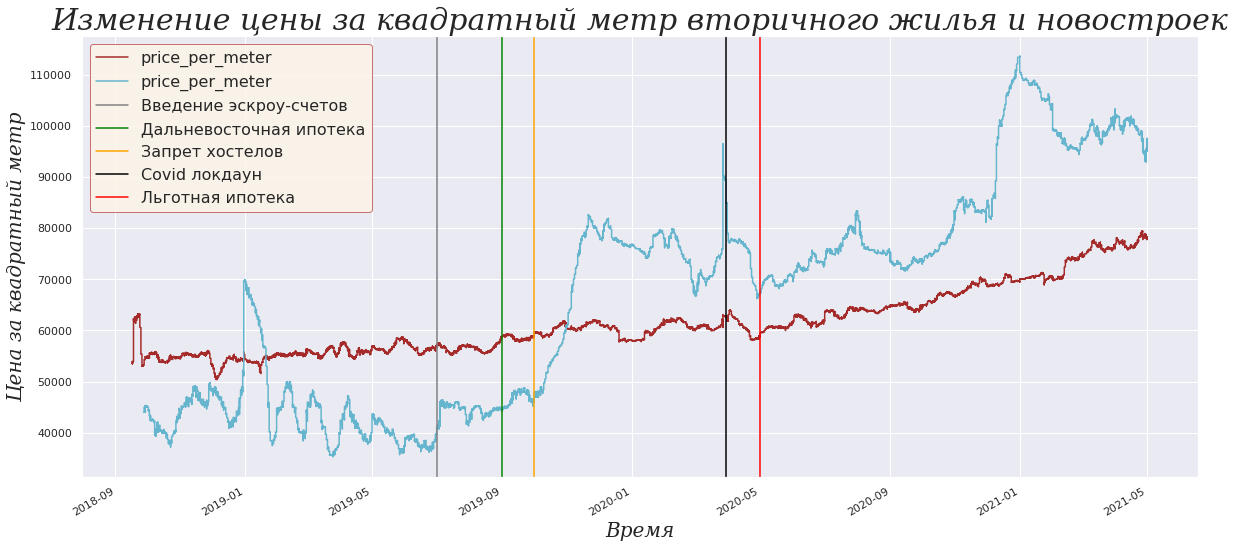

In [55]:
plt.figure(figsize = (20,9))
old.rolling(5000).median().plot(color = 'brown')
new.rolling(5000).median().plot(color = 'c')
plt.title('Изменение цены за квадратный метр вторичного жилья и новостроек', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 30)
plt.xlabel('Время', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 20)
plt.ylabel('Цена за квадратный метр', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 20)
plt.axvline (x=mpl.dates.datestr2num('2019-07-01'), color = 'grey', label = 'Введение эскроу-счетов')
plt.axvline (x=mpl.dates.datestr2num('2019-09-01'), color = 'green', label = 'Дальневосточная ипотека')
plt.axvline (x=mpl.dates.datestr2num('2019-10-01'), color = 'orange', label = 'Запрет хостелов')
plt.axvline (x=mpl.dates.datestr2num('2020-03-30'), color = 'black', label = 'Covid локдаун')
plt.axvline (x=mpl.dates.datestr2num('2020-05-01'), color = 'red', label = 'Льготная ипотека')
plt.minorticks_on()
#plt.grid(which = 'major', color = 'red', linewidth = 0.8, linestyle = '--')
#plt.grid(which = 'minor', color = 'green', linewidth = 0.5, linestyle = '--')
plt.legend(fontsize = 16,
          ncol = 1, #  количество столбцов
          facecolor = 'oldlace',    #  цвет области
          edgecolor = 'r',    #  цвет крайней линии
          #title = 'Важные события отрасли',    #  заголовок
          title_fontsize = '18'    #  размер шрифта заголовка
         )
plt.show()

**Цена квадратного метра по стране растет, на что повлияли следующие события**

**События 2019**
1 июля - переход на эскроу-счета, застройщик до окончания строительства не может пользоваться деньгами дольщиков. Следствие - консолидация рынка в руках крыпных игроков, имеющих больше оборотных автивов, и уход малых.

1 сентября - запуск Дальневосточной специальной ипотечной программы со ставкой 2%.

1 октября - запрет хостелов с жилых помещениях. Оказывает поддержку ценам за квадратный метр. Стоимость квартир в домах, где появляется хостел, снижается на треть.

21 ноября - Ввод в эксплуатацию МЦД-1, МЦД-2 для Москвы и Московской области - рост цен на жилье вблизи диаметров - от 10 до 40%.


**События 2020**

Ковид - снижение объема строительства на 30% весной и антикризисные меры правительства.

Весна - Введение льготной ипотеки под 6,5% годовых на новостройки. Благодаря этой программе в России уже к ноябрю был установлен годовой рекорд выдачи жилищных кредитов — 3,2 трлн руб. Однако ажиотажный спрос на льготную ипотеку привел к значительному повышению цен на новостройки и вторичное жилье.

Программа субсидирования кредитов застройщикам, чтобы средства максимально вкладывались в стройку, а не погашение кредитов.

**События 2021**

Продолжение роста цен на недвижимость из-за программы льготной ипотеки.

Новый годовой рекорд выдачи жилищных кредитов — 5 трлн руб

Рост себестоимости строительства из-за подорожания стройматериалов, разрыва цепочек поставок по всему миру и нехватки рабочих рук на стройках, что также увеличивает цену квадратного метра.

**Распределение количества объектов по стоимости за квадратный метр**

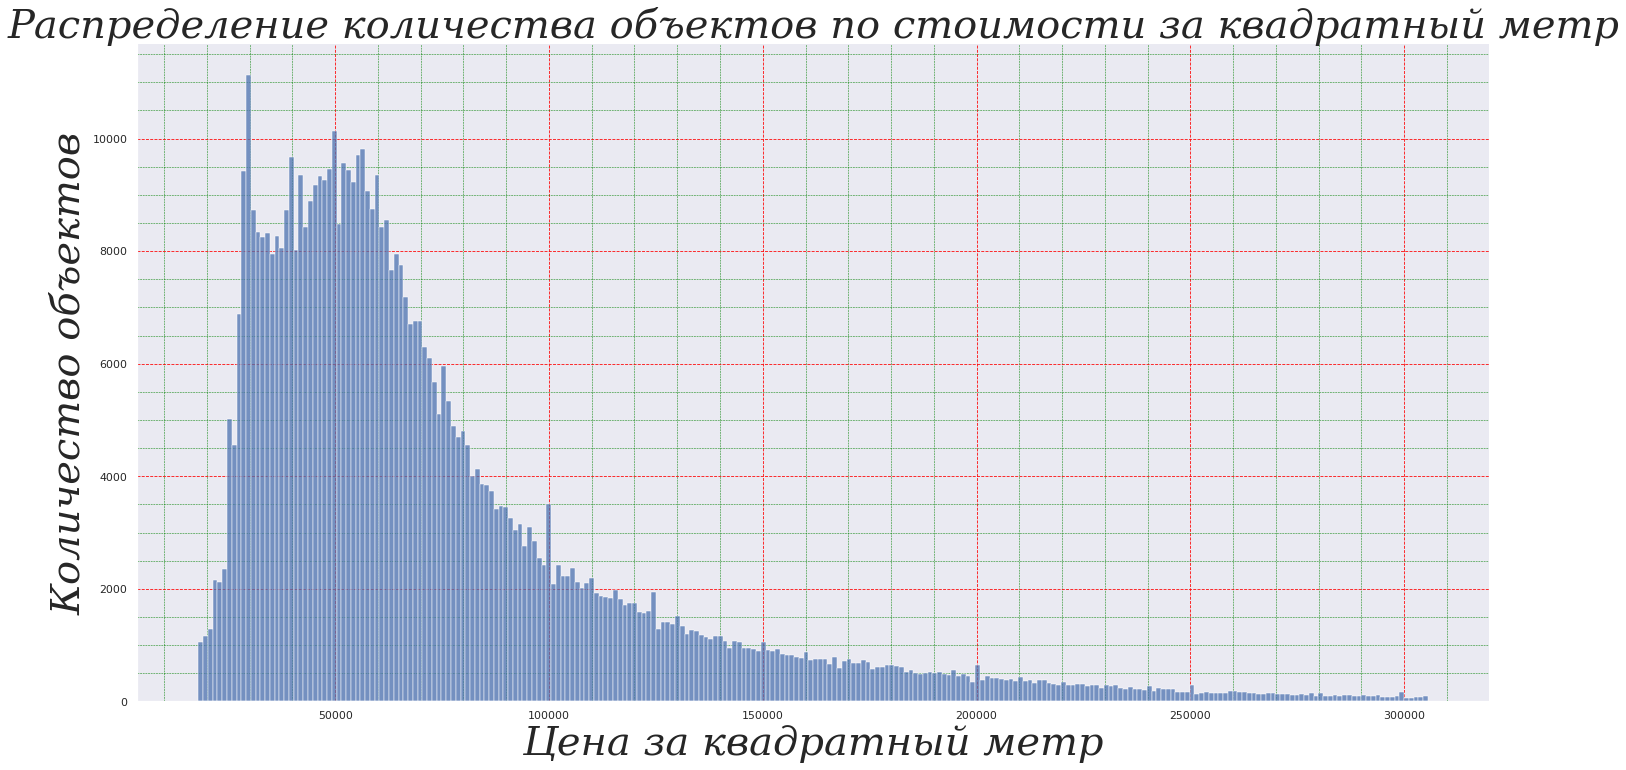

In [56]:
sns.displot(data['price_per_meter'], height= 10 , aspect= 2)
plt.title('Распределение количества объектов по стоимости за квадратный метр', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 40)
plt.xlabel('Цена за квадратный метр', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 40)
plt.ylabel('Количество объектов', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 40)
plt.minorticks_on()
plt.grid(which = 'major', color = 'red', linewidth = 0.8, linestyle = '--')
plt.grid(which = 'minor', color = 'green', linewidth = 0.5, linestyle = '--')
#plt.legend()
plt.show()

In [57]:
data.groupby('region').count()

,Unnamed: 0,price,time,geo_lat,geo_lon,building_type,level,levels,rooms,area,kitchen_area,object_type,price_per_meter
region,,,,,,,,,,,,,
Адыгея,563,563,563,563,563,563,563,563,563,563,563,563,563
Алтайский край,7757,7757,7757,7757,7757,7757,7757,7757,7757,7757,7757,7757,7757
Амурская область,250,250,250,250,250,250,250,250,250,250,250,250,250
Архангельская область,418,418,418,418,418,418,418,418,418,418,418,418,418
Астраханская область,163,163,163,163,163,163,163,163,163,163,163,163,163
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Челябинская область,16699,16699,16699,16699,16699,16699,16699,16699,16699,16699,16699,16699,16699
Чеченская Республика,253,253,253,253,253,253,253,253,253,253,253,253,253
Чувашия,5985,5985,5985,5985,5985,5985,5985,5985,5985,5985,5985,5985,5985


# **6. В каких регионах рынок недвижимости растет? А в каких падает?**

**Сброс индекса с поля date**

In [58]:
data.reset_index(inplace= True )

**Составление графика динамики цены за квадратный метр по годам по каждому региону**

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


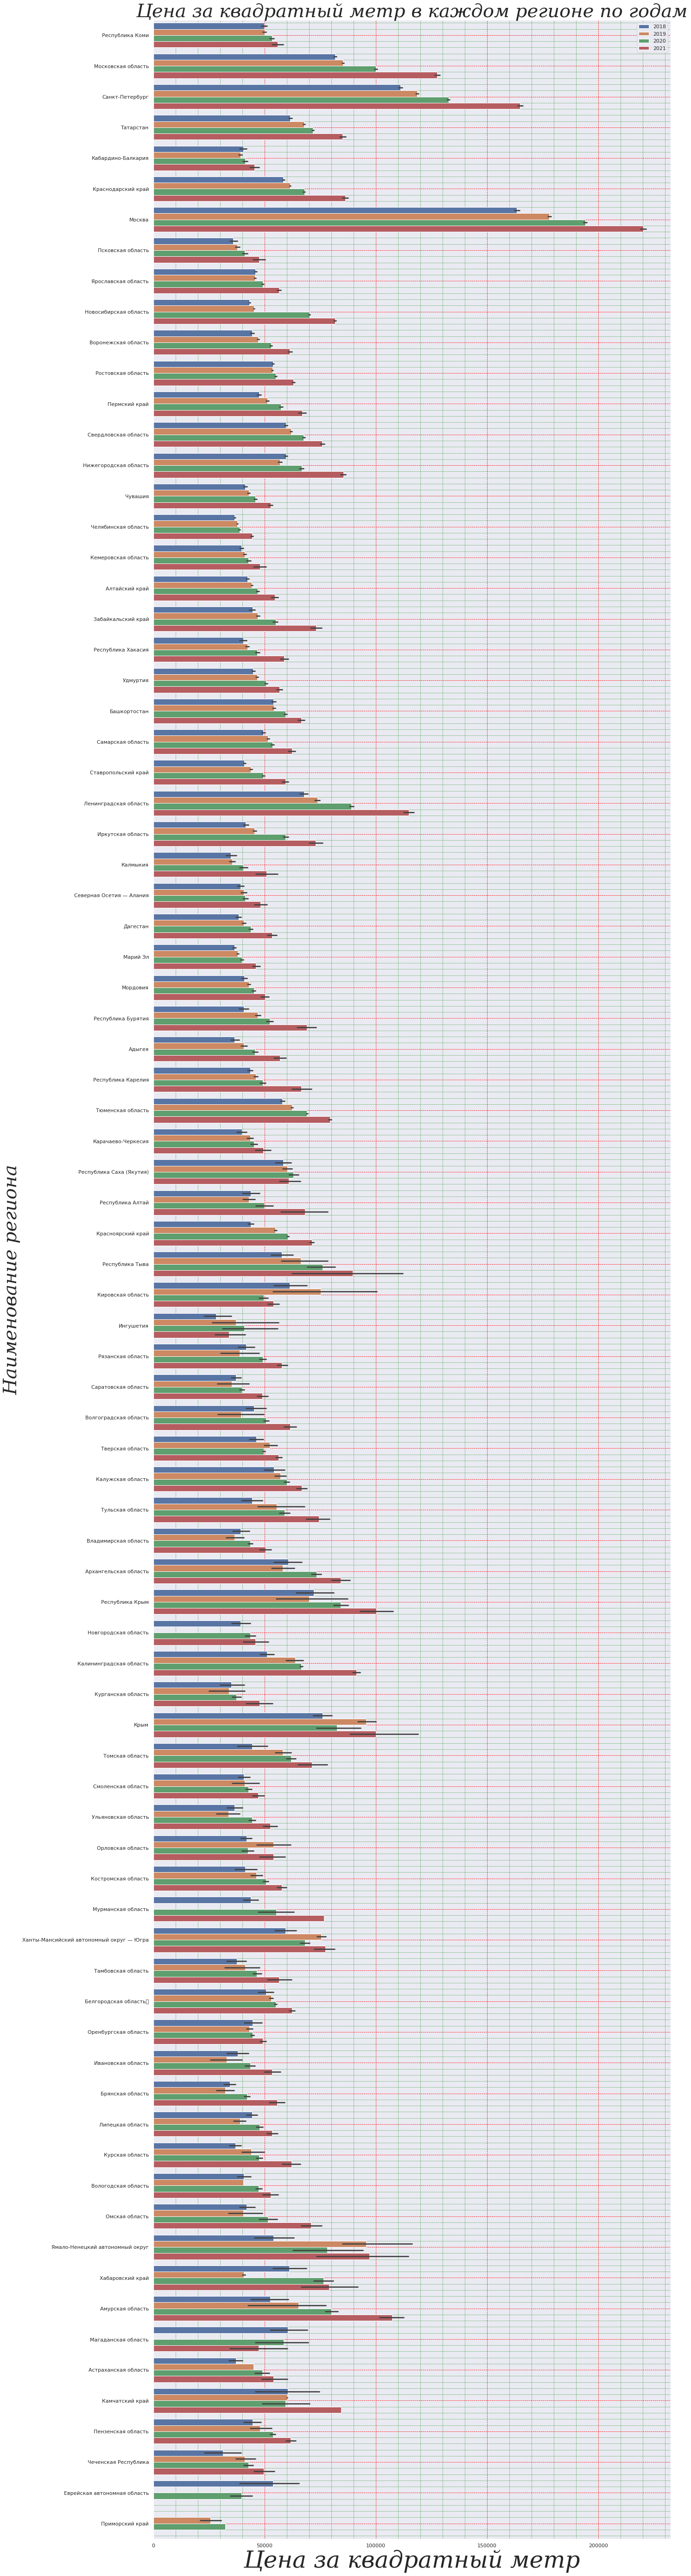

In [59]:
plt.figure(figsize = (20,100))
sns.barplot(data=data, x='price_per_meter', y='region', hue=data['date'].dt.year)
plt.title('Цена за квадратный метр в каждом регионе по годам', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 40)
plt.xlabel('Цена за квадратный метр', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 50)
plt.ylabel('Наименование региона', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 40)
plt.minorticks_on()
plt.grid(which = 'major', color = 'red', linewidth = 0.8, linestyle = '--')
plt.grid(which = 'minor', color = 'green', linewidth = 0.5, linestyle = '--')
plt.legend()
plt.show()

**Снижение стоимости квадратного метра зафиксировано в Кировской, Еврейской, Магаданской областях в Ингушетии и Приморском крае. Рост выше, чем в целом по стране зафиксирован в Москве и Московской области, Санкт-Петербурге и Ленинградской области, Краснодарском крае, Новосибирской и Амурской областях. Основной вклад в рост квадратного метра недвижимости вносит 2021 год.**

**Визуально выбираю указанные регионы в три отдельные переменные**

In [60]:
sample_reg_low = data.loc[data['region'].isin(['Кировская область', 'Еврейская автономная область', 'Магаданская область', 
                                            'Ингушетия', 'Приморский край'])]
sample_reg_high = data.loc[data['region'].isin(['Москва', 'Московская область', 'Санкт-Петербург', 'Ленинградская область',
                                                'Краснодарский край', 'Амурская область', 
                                                'Новосибирская область'])]
sample_dal_vost = data.loc[data['region'].isin(['Республика Бурятия', 'Республика Саха (Якутия)', 'Камчатский край',
                                                'Хабаровский край', 'Забайкальский край', 'Приморский край', 
                                                'Еврейская автономная область', 'Магаданская область'])]

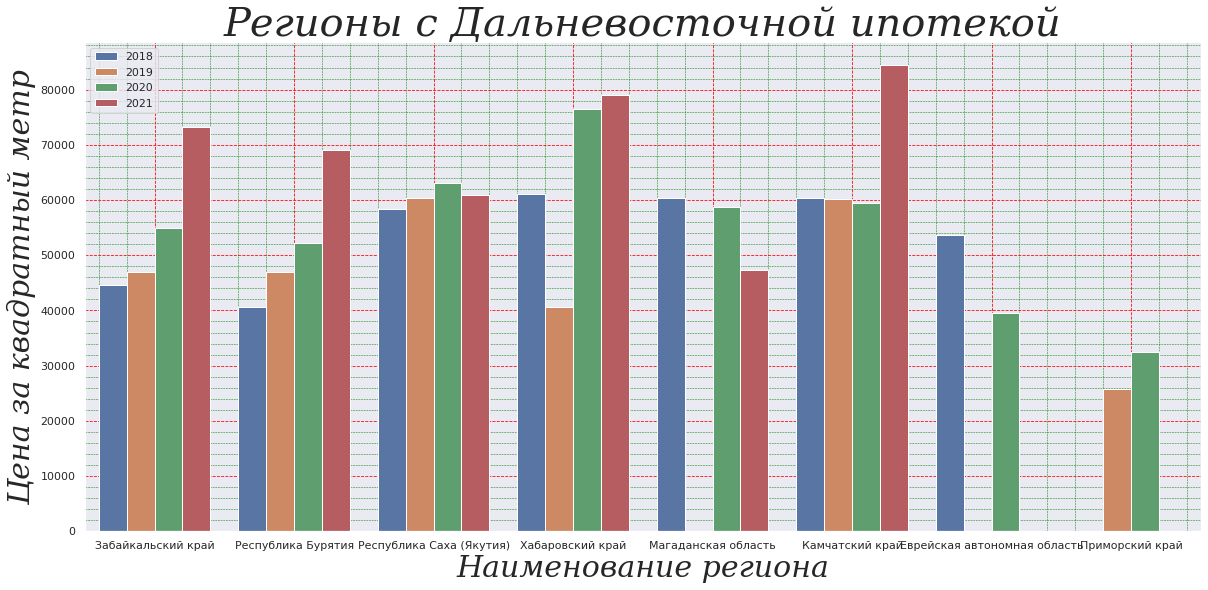

In [61]:
plt.figure(figsize = (20,9))
sns.barplot(data=sample_dal_vost, y='price_per_meter', x='region', hue=data['date'].dt.year, ci = None)
plt.title('Регионы с Дальневосточной ипотекой', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 40)
plt.ylabel('Цена за квадратный метр', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 30)
plt.xlabel('Наименование региона', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 30)
plt.minorticks_on()
plt.grid(which = 'major', color = 'red', linewidth = 0.8, linestyle = '--')
plt.grid(which = 'minor', color = 'green', linewidth = 0.5, linestyle = '--')
plt.legend()
plt.show()

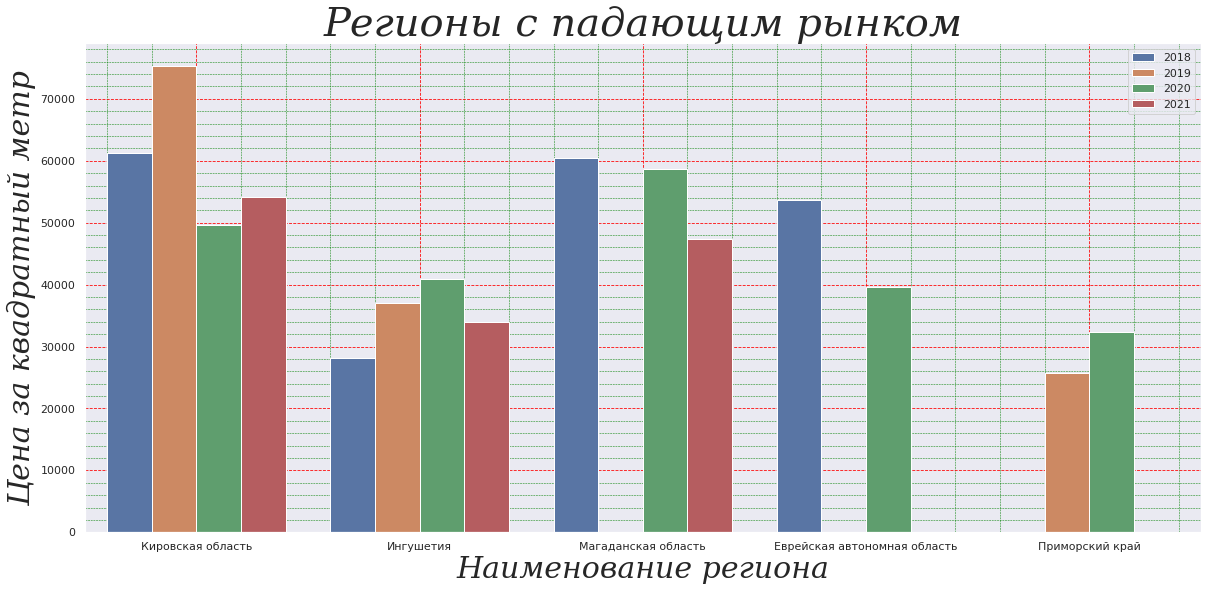

In [62]:
plt.figure(figsize = (20,9))
sns.barplot(data=sample_reg_low, y='price_per_meter', x='region', hue=data['date'].dt.year, ci = None)
plt.title('Регионы с падающим рынком', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 40)
plt.ylabel('Цена за квадратный метр', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 30)
plt.xlabel('Наименование региона', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 30)
plt.minorticks_on()
plt.grid(which = 'major', color = 'red', linewidth = 0.8, linestyle = '--')
plt.grid(which = 'minor', color = 'green', linewidth = 0.5, linestyle = '--')
plt.legend()
plt.show()

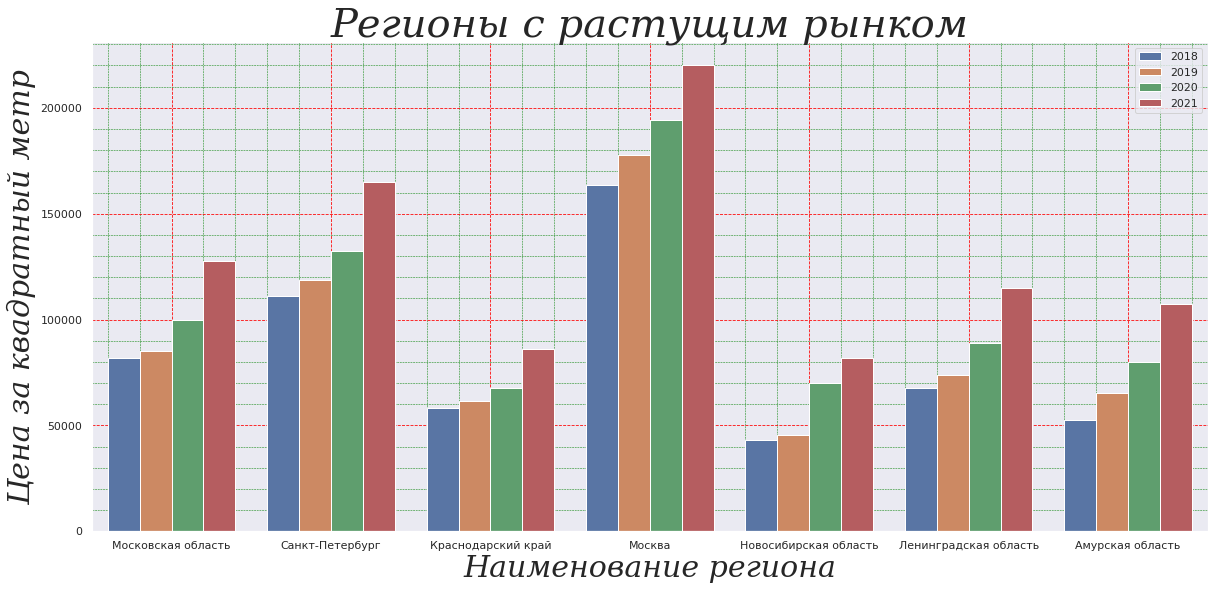

In [63]:
plt.figure(figsize = (20,9))
sns.barplot(data=sample_reg_high, y='price_per_meter', x='region', hue=data['date'].dt.year, ci = None)
plt.title('Регионы с растущим рынком', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 40)
plt.ylabel('Цена за квадратный метр', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 30)
plt.xlabel('Наименование региона', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 30)
plt.minorticks_on()
plt.grid(which = 'major', color = 'red', linewidth = 0.8, linestyle = '--')
plt.grid(which = 'minor', color = 'green', linewidth = 0.5, linestyle = '--')
plt.legend()
plt.show()

# **7. В покупку квартир какого сегмента вы бы инвестировали и почему?**

**Рассматриваю данные на примере Ярославской области, там где сейчас живу**

In [65]:
data.set_index('date', inplace = True)

In [66]:
data_yar_old = data.loc[(data['region'] == 'Ярославская область') & (data['object_type'] == 1)]['price_per_meter']
data_yar_new = data.loc[(data['region'] == 'Ярославская область') & (data['object_type'] == 11)]['price_per_meter']

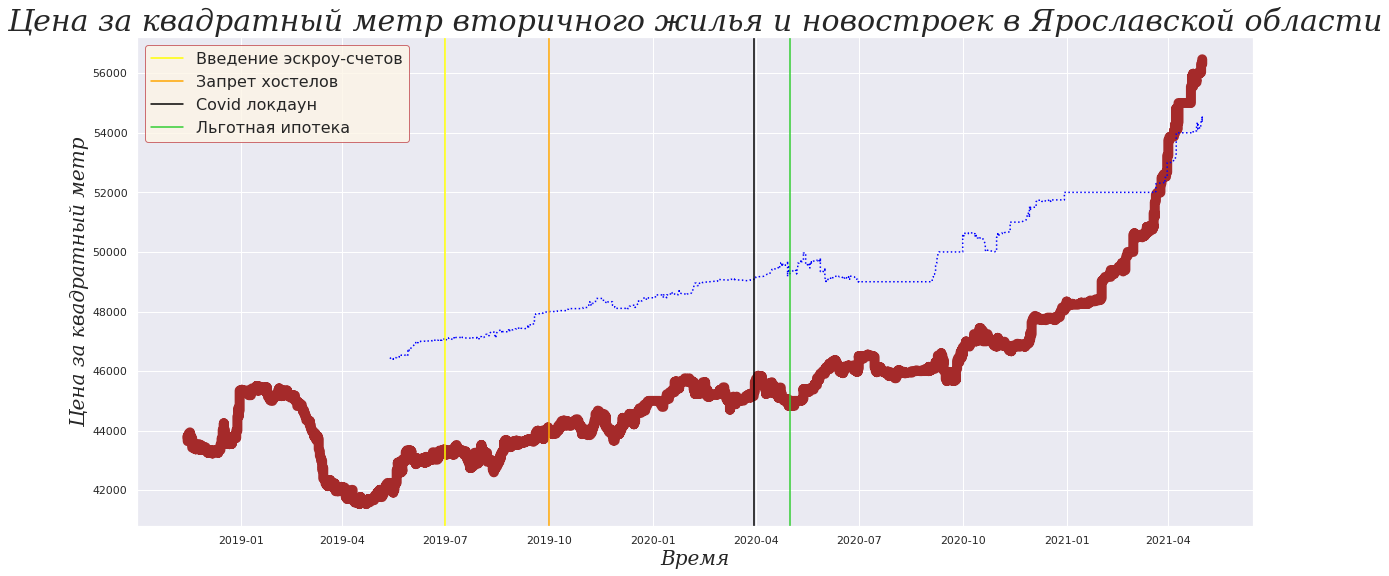

In [67]:
plt.figure(figsize = (20,9))
plt.plot(data_yar_old.rolling(700).median(), color = 'brown', linewidth = 10)
plt.plot(data_yar_new.rolling(700).median(), color = 'blue', linestyle = ':')
plt.title('Цена за квадратный метр вторичного жилья и новостроек в Ярославской области', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 30)
plt.xlabel('Время', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 20)
plt.ylabel('Цена за квадратный метр', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 20)
plt.axvline (x=mpl.dates.datestr2num('2019-07-01'), color = 'yellow', label = 'Введение эскроу-счетов')
plt.axvline (x=mpl.dates.datestr2num('2019-10-01'), color = 'orange', label = 'Запрет хостелов')
plt.axvline (x=mpl.dates.datestr2num('2020-03-30'), color = 'black', label = 'Covid локдаун')
plt.axvline (x=mpl.dates.datestr2num('2020-05-01'), color = 'limegreen', label = 'Льготная ипотека')
plt.minorticks_on()
plt.legend(fontsize = 16,
          ncol = 1, #  количество столбцов
          facecolor = 'oldlace',    #  цвет области
          edgecolor = 'r',    #  цвет крайней линии
          #title = 'Важные события отрасли',    #  заголовок
          title_fontsize = '18'    #  размер шрифта заголовка
         )
plt.show()

**На мой взгляд, недвижимость - это стабильный и ликвидный актив для сохранения сбережений и последующей сдачи недвижимости в долгосрочную аренду. Я бы выбрал классические советские 1-комнатные хрущевки в 5-этажных зданиях из красного кирпича, этажи с 3 по 5, в спальном районе, но в 2-3 минутах от остановки общественного транспорта. Причины: 1-комнатные квартиры наиболее востребованы потенциальными арендаторами (может снимать как семья, так и пара или один человек). Причем время показало, что даже введенная государством программа льготной ипотеки не влияет на спрос 1-комнатных квартир. Снимая 1-комнатную квартиру, люди параллельно копят на первый взнос по ипотеке. Доходность относительно цены квадратного метра составляет 7,5-8% годовых. И она больше, чем при сдаче 2-комнатной квартиры. К дополнительной доходности можно отнести и рост стоимости квадратного метра за последние 5 лет. Коммуникации в зданиях этого типа до сих пор обладают приличным запасом надежности и, по словам сантехников, на внутриквартирных участках приносят меньше проблем жильцам. Вероятность ремонта у соседей ниже, чем в новостройках. Условия слышимости в сравнении с теми же новостройками - лучше. В здании этого проекта нет лифтов, что также снижает уровень шума. Также если нужно срочно решить жилищный вопрос в городской черте - то данный вариант -  минимальный по цене и лучший по соотношению цена/качество**

# **Распределение плотности объектов недвижимости по цене за квадратный метр**

/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.8/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


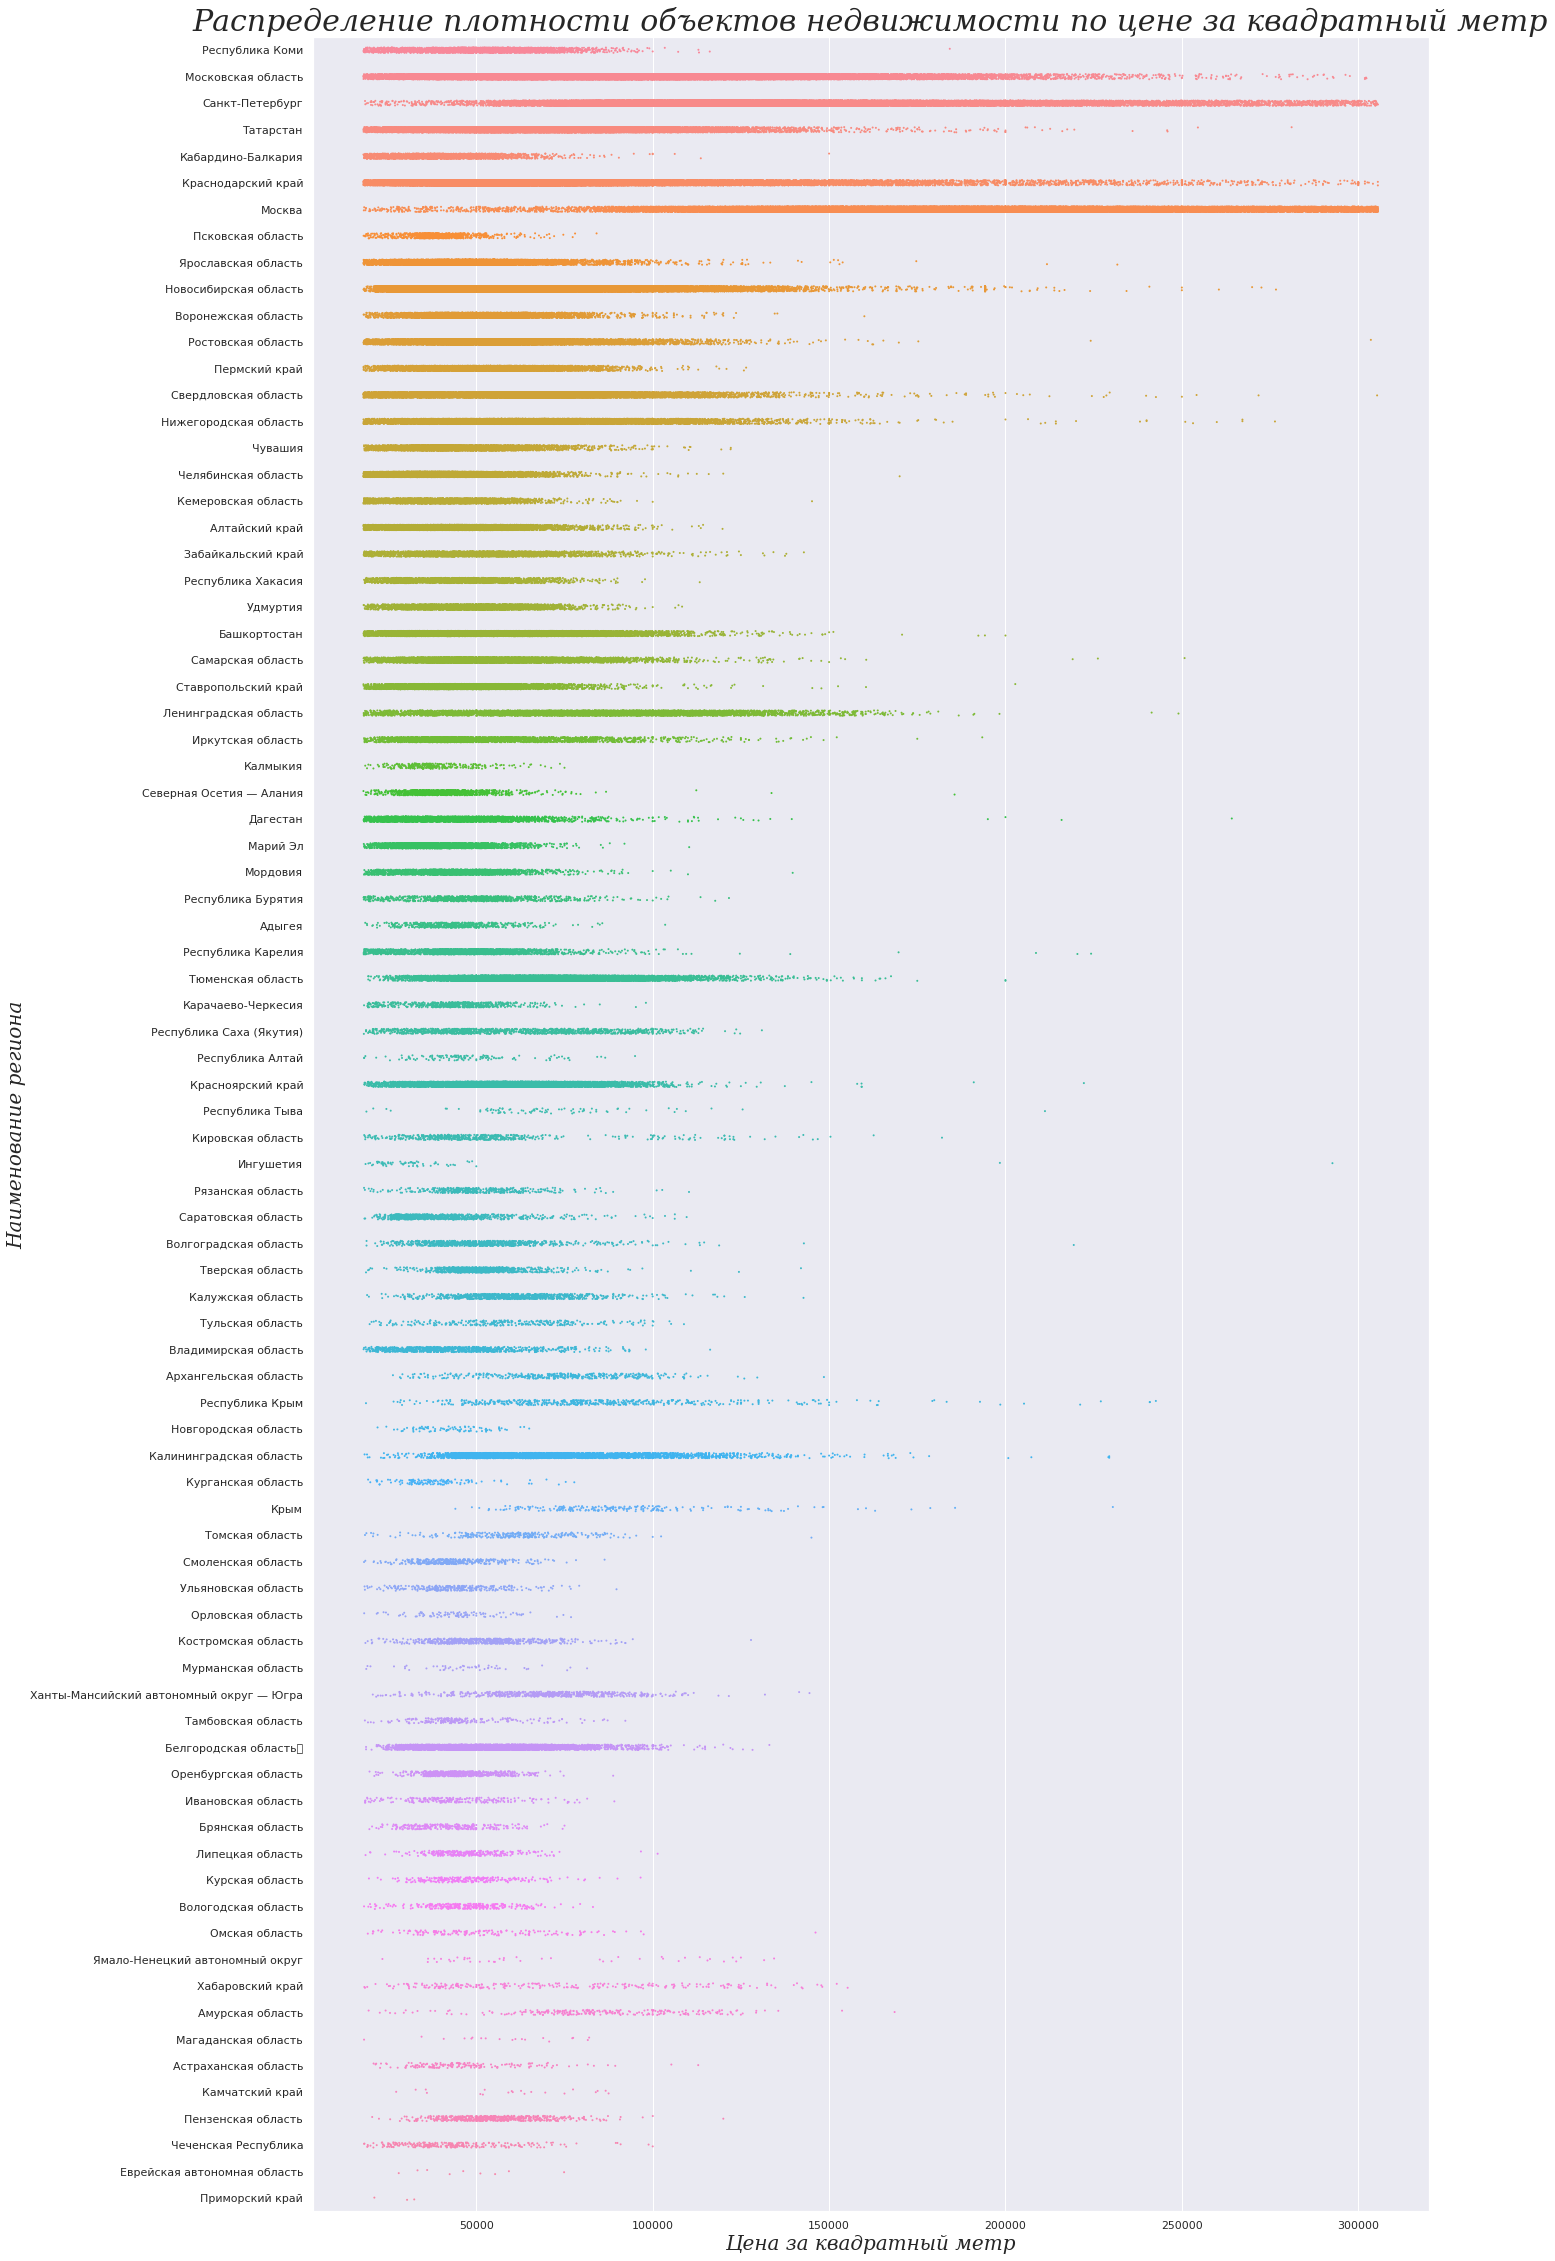

In [64]:
plt.figure(figsize = (20,40))
sns.stripplot(data = data, y = 'region', x = 'price_per_meter', size = 2)
plt.title('Распределение плотности объектов недвижимости по цене за квадратный метр', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 30)
plt.xlabel('Цена за квадратный метр', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 20)
plt.ylabel('Наименование региона', fontfamily = 'serif',
                fontstyle = 'italic',fontsize = 20)
plt.minorticks_on()
#plt.grid(which = 'major', color = 'red', linewidth = 0.8, linestyle = '--')
#plt.grid(which = 'minor', color = 'green', linewidth = 0.5, linestyle = '--')
#plt.legend()
plt.show()

# **Дашборд в Yandex Datalens**

**Подготовка датасета для BI системы**

Чтение предоставленного датасета

In [71]:
data = pd.read_csv('data.csv')

Переименование кодов региона в их название

In [72]:
data.loc[data['region'] == 3, 'region' ] = 'Москва'
data.loc[data['region'] == 69, 'region' ] = 'Еврейская автономная область'
data.loc[data['region'] == 81, 'region' ] = 'Московская область'
data.loc[data['region'] == 821, 'region' ] = 'Брянская область'
data.loc[data['region'] == 1010, 'region' ] = 'Удмуртия'
data.loc[data['region'] == 1491, 'region' ] = 'Рязанская область'
data.loc[data['region'] == 2072, 'region' ] = 'Воронежская область'
data.loc[data['region'] == 2328, 'region' ] = 'Калужская область'
data.loc[data['region'] == 2359, 'region' ] = 'Республика Хакасия'
data.loc[data['region'] == 2484, 'region' ] = 'Ханты-Мансийский автономный округ — Югра'
data.loc[data['region'] == 2528, 'region' ] = 'Саратовская область'
data.loc[data['region'] == 2594, 'region' ] = 'Кировская область'
data.loc[data['region'] == 2604, 'region' ] = 'Ярославская область'
data.loc[data['region'] == 2661, 'region' ] = 'Санкт-Петербург'
data.loc[data['region'] == 2722, 'region' ] = 'Башкортостан'
data.loc[data['region'] == 2806, 'region' ] = 'Тамбовская область'
data.loc[data['region'] == 2814, 'region' ] = 'Орловская область'
data.loc[data['region'] == 2843, 'region' ] = 'Краснодарский край'
data.loc[data['region'] == 2860, 'region' ] = 'Кемеровская область'
data.loc[data['region'] == 2871, 'region' ] = 'Нижегородская область'
data.loc[data['region'] == 2880, 'region' ] = 'Тверская область'
data.loc[data['region'] == 2885, 'region' ] = 'Чеченская Республика'
data.loc[data['region'] == 2900, 'region' ] = 'Ставропольский край'
data.loc[data['region'] == 2922, 'region' ] = 'Татарстан'
data.loc[data['region'] == 3019, 'region' ] = 'Чувашия'
data.loc[data['region'] == 3106, 'region' ] = 'Самарская область'
data.loc[data['region'] == 3153, 'region' ] = 'Оренбургская область'
data.loc[data['region'] == 3230, 'region' ] = 'Ростовская область'
data.loc[data['region'] == 3446, 'region' ] = 'Ленинградская область'
data.loc[data['region'] == 3870, 'region' ] = 'Красноярский край'
data.loc[data['region'] == 3991, 'region' ] = 'Тюменская область'
data.loc[data['region'] == 4007, 'region' ] = 'Дагестан'
data.loc[data['region'] == 4086, 'region' ] = 'Хабаровский край'
data.loc[data['region'] == 4189, 'region' ] = 'Костромская область'
data.loc[data['region'] == 4240, 'region' ] = 'Липецкая область'
data.loc[data['region'] == 4249, 'region' ] = 'Ульяновская область'
data.loc[data['region'] == 4374, 'region' ] = 'Вологодская область'
data.loc[data['region'] == 4417, 'region' ] = 'Республика Коми'
data.loc[data['region'] == 4695, 'region' ] = 'Волгоградская область'
data.loc[data['region'] == 4963, 'region' ] = 'Приморский край'
data.loc[data['region'] == 4982, 'region' ] = 'Марий Эл'
data.loc[data['region'] == 5143, 'region' ] = 'Тульская область'
data.loc[data['region'] == 5178, 'region' ] = 'Республика Тыва'
data.loc[data['region'] == 5241, 'region' ] = 'Мордовия'
data.loc[data['region'] == 5282, 'region' ] = 'Челябинская область'
data.loc[data['region'] == 5368, 'region' ] = 'Иркутская область'
data.loc[data['region'] == 5520, 'region' ] = 'Пермский край'
data.loc[data['region'] == 5703, 'region' ] = 'Курганская область'
data.loc[data['region'] == 5736, 'region' ] = 'Новгородская область'
data.loc[data['region'] == 5789, 'region' ] = 'Владимирская область'
data.loc[data['region'] == 5794, 'region' ] = 'Смоленская область'
data.loc[data['region'] == 5952, 'region' ] = 'Белгородская область	'
data.loc[data['region'] == 5993, 'region' ] = 'Пензенская область'
data.loc[data['region'] == 6171, 'region' ] = 'Свердловская область'
data.loc[data['region'] == 6309, 'region' ] = 'Республика Алтай'
data.loc[data['region'] == 6543, 'region' ] = 'Архангельская область'
data.loc[data['region'] == 6817, 'region' ] = 'Алтайский край'
data.loc[data['region'] == 6937, 'region' ] = 'Республика Крым'
data.loc[data['region'] == 7121, 'region' ] = 'Курская область'
data.loc[data['region'] == 7793, 'region' ] = 'Псковская область'
data.loc[data['region'] == 7873, 'region' ] = 'Крым'
data.loc[data['region'] == 7896, 'region' ] = 'Калининградская область'
data.loc[data['region'] == 7929, 'region' ] = 'Амурская область'
data.loc[data['region'] == 8090, 'region' ] = 'Республика Карелия'
data.loc[data['region'] == 8509, 'region' ] = 'Калмыкия'
data.loc[data['region'] == 8640, 'region' ] = 'Омская область'
data.loc[data['region'] == 8894, 'region' ] = 'Ивановская область'
data.loc[data['region'] == 9579, 'region' ] = 'Республика Бурятия'
data.loc[data['region'] == 9648, 'region' ] = 'Кабардино-Балкария'
data.loc[data['region'] == 9654, 'region' ] = 'Новосибирская область'
data.loc[data['region'] == 10160, 'region' ] = 'Забайкальский край'
data.loc[data['region'] == 10201, 'region' ] = 'Томская область'
data.loc[data['region'] == 10582, 'region' ] = 'Астраханская область'
data.loc[data['region'] == 11171, 'region' ] = 'Республика Саха (Якутия)'
data.loc[data['region'] == 11416, 'region' ] = 'Адыгея'
data.loc[data['region'] == 11991, 'region' ] = 'Карачаево-Черкесия'
data.loc[data['region'] == 13098, 'region' ] = 'Камчатский край'
data.loc[data['region'] == 13913, 'region' ] = 'Ингушетия'
data.loc[data['region'] == 13919, 'region' ] = 'Северная Осетия — Алания'
data.loc[data['region'] == 14368, 'region' ] = 'Мурманская область'
data.loc[data['region'] == 14880, 'region' ] = 'Ямало-Ненецкий автономный округ'
data.loc[data['region'] == 16705, 'region' ] = 'Магаданская область'

Перевод поля date из формата object в формат datetime64

In [73]:
data['date'] = pd.to_datetime(data['date'])

Отрицательные значения найдены в полях price и rooms. Известно, что значение -1 в поле rooms означает квартиру-студию. Допускаю, что ошибка -2 в поле rooms - это опечатка, поэтому: -2 исправляю на 2. Для BI системы приравниваю студии к однокомнатным квартирам: -1 исправляю на 1. 

In [74]:
data.loc[data['rooms'] == -2, 'rooms'] = 2
data.loc[data['rooms'] == -1, 'rooms'] = 1

Расчет дополнительного поля - цены за квадратный метр для конкретного объекта. Исхожу из того. что значение в поле kitchen_area является частью поля area, и складывать их не нужно.

In [75]:
data['price_per_meter'] = round(data['price'] / data['area'], 2)

Выявление и удаление объектов с явно нереалистичной ценой за квадратный метр (либо слишком малой, либо слишком большой), получившейся из-за неверно заполненных значений в полях этих строк.

In [76]:
Q_01 = data['price_per_meter'].quantile(0.01) # 1% граница нижнего ценового диапазона за кв.м
Q_99 = data['price_per_meter'].quantile(0.99) # 99% граница верхнего ценового диапазона за кв.м
data_err = data[(data['price_per_meter'] < Q_01 ) | (data['price_per_meter'] > Q_99)]
print(f'1% граница нижнего ценового диапазона за кв.м: {Q_01} рублей')
print(f'99% граница верхнего ценового диапазона за кв.м: {Q_99} рублей')
print(f'Всего объектов с явно нереалистичной ценой: {len(data_err)}')

1% граница нижнего ценового диапазона за кв.м: 18000.0 рублей
99% граница верхнего ценового диапазона за кв.м: 305588.4800000002 рублей
Всего объектов с явно нереалистичной ценой: 11985


In [77]:
data = data[(data['price_per_meter'] > Q_01 ) & (data['price_per_meter'] < Q_99)]

In [78]:
data.count()

Unnamed: 0         587961
price              587961
date               587961
time               587961
geo_lat            587961
geo_lon            587961
region             587961
building_type      587961
level              587961
levels             587961
rooms              587961
area               587961
kitchen_area       587961
object_type        587961
price_per_meter    587961
dtype: int64

Сохранение датасета с внесенными изменениями для последующей загрузки в BI систему

In [ ]:
data.to_csv(r'C:\df.csv', sep= ',', index=False)

**1. Объем предложения жилого фонда на рынке в зависимости от этажности зданий в каждом регионе**

**2. Объем предложения жилого фонда на рынке в зависимости от этажа, на котором находится объект**

**3.Объем предложения жилого фонда на рынке в зависимости от количества комнат**

**4.Объем предложения жилого фонда на рынке в зависимости от типа здания**

**5.Средняя стоимость квадратного метра в зависимости от этажа нахождения объекта**

**6.Средняя стоимость квадратного метра в зависимости от количества комнат в квартире**

**7. Средняя площадь кухни в зависимости от количества комнат в квартире**

**8.Соотношение объема предложения на вторичном рынке и новостроек с распределением по количеству комнат объекта**

**Обоснование - узнать изменения**

Ссылка на дашборд: ...

https://datalens.yandex.ru/tplr3eg1a3nyj-nedvizhimost-rf